In [1]:
# Setting up a custom stylesheet in IJulia
file = open("style.css") # A .css file in the same folder as this notebook file
styl = readall(file) # Read the file
HTML("$styl") # Output as HTML

HTML{ASCIIString}("<link href='http://fonts.googleapis.com/css?family=Alegreya+Sans:100,300,400,500,700,800,900,100italic,300italic,400italic,500italic,700italic,800italic,900italic' rel='stylesheet' type='text/css'>\n<link href='http://fonts.googleapis.com/css?family=Arvo:400,700,400italic' rel='stylesheet' type='text/css'>\n<link href='http://fonts.googleapis.com/css?family=PT+Mono' rel='stylesheet' type='text/css'>\n<link href='http://fonts.googleapis.com/css?family=Shadows+Into+Light' rel='stylesheet' type='text/css'>\n<link href='http://fonts.googleapis.com/css?family=Philosopher:400,700,400italic,700italic' rel='stylesheet' type='text/css'>\n\n<style>\n\n@font-face {\n    font-family: \"Computer Modern\";\n    src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf');\n}\n\n#notebook_panel { /* main background */\n    background: #ddd;\n    color: #000000;\n}\n\n\n\n/* Formatting for header cells */\n.text_cell_render h1 {\n    font-family: 'Philosopher', sans-serif;\n    font-weight: 400;\n    font-size: 2.2em;\n    line-height: 100%;\n    color: rgb(0, 80, 120);\n    margin-bottom: 0.1em;\n    margin-top: 0.1em;\n    display: block;\n}\t\n.text_cell_render h2 {\n    font-family: 'Philosopher', serif;\n    font-weight: 400;\n    font-size: 1.9em;\n    line-height: 100%;\n    color: rgb(200,100,0);\n    margin-bottom: 0.1em;\n    margin-top: 0.1em;\n    display: block;\n}\t\n\n.text_cell_render h3 {\n    font-family: 'Philosopher', serif;\n    margin-top:12px;\n    margin-bottom: 3px;\n    font-style: italic;\n    color: rgb(94,127,192);\n}\n\n.text_cell_render h4 {\n    font-family: 'Philosopher', serif;\n}\n\n.text_cell_render h5 {\n    font-family: 'Alegreya Sans', sans-serif;\n    font-weight: 300;\n    font-size: 16pt;\n    color: grey;\n    font-style: italic;\n    margin-bottom: .1em;\n    margin-top: 0.1em;\n    display: block;\n}\n\n.text_cell_render h6 {\n    font-family: 'PT Mono', sans-serif;\n    font-weight: 300;\n    font-size: 10pt;\n    color: grey;\n    margin-bottom: 1px;\n    margin-top: 1px;\n}\n\n.CodeMirror{\n        font-family: \"PT Mono\";\n        font-size: 100%;\n}\n\n</style>\n\n")

<h1> Using the data: a rough fit of the model parameters </h1>

<h2>In this lecture</h2>

- [Outcome](#Outcome)
- [Total cases data: observation vs model](#Total-cases-data:-observation-vs-model)
- [Interactively fitting the model to data using the notebook](#Interactively-fitting-the-model-to-data-using-the-notebook)


[Back to the top](#In-this-lecture)

<h2>Outcome</h2>

After this lecture, you will be able to
- Extract total number of cases per epidemic day from a a run of our EVD model
- Use a plot to compare model values to observed values
- Use the interactive notebook to adjust $\lambda$, $\gamma$ and $S(0)$ 
- Estimate quickly a fairly good set of values by improving the fit of the model to the data

[Back to the top](#In-this-lecture)

<h2>Total cases data: observation vs model</h2>

When one fits data to a model, the first thing is to ensure that the numbers from the model and the numbers from observation really represent the same thing.

In this case, the data reported in Wikipedia are of two kinds: total cases to date, and total deaths. Our model does not include deaths, so we cannot use that data. Moreover, in our model there is no explicit record of the number of cases. Therefore we have first to work out how to get our model to tell us what the total number of cases are.

Fortunately, that is not hard. The total cases to date is the number of people who have ever been infected. But every such person is either in the infected group currently or has moved to the removed group. So the total number of cases at time $t$ is $I(t) + R(t)$. We will use $C(t)$ to denote the modelled number of cases, and $W(t)$ for the reported number of cases from Wikipedia.

Let us rerun the model as we left it at the end of the previous lecture, with the estimates from there:

In [7]:
using Plots  # might as well start by loading Plots and choose to use the PyPlot backend
pyplot()

# now lets get the total cases data
EVDdata            = readdlm("wikipediaEVDdatesconverted.csv", ',')
tvalsfromdata      = EVDdata[:,1]  # the epidemic day values
totalcasesfromdata = EVDdata[:, 2]    # we'll extract individual countries when we need them

# here's the function that drives the changes that happen every time step
function updateSIR(popnvector)       # exactly the same function as before
    susceptibles = popnvector[1];
    infecteds    = popnvector[2]; 
    removeds     = popnvector[3];
    newS = susceptibles - lambda*susceptibles*infecteds*dt
    newI = infecteds + lambda*susceptibles*infecteds*dt - gam*infecteds*dt  
    newR = removeds + gam*infecteds*dt
    return [newS newI newR] 
end

# this cell we need to run only once

updateSIR (generic function with 1 method)


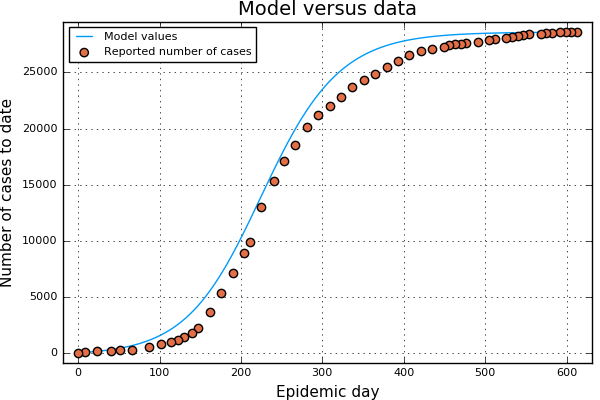

In [19]:
# set parameter values
lambda = 1.47*10^-6.   # infection rate parameter (assumes rates are per day)
gam = 1/8.      # recovery rate parameter  (ditto)
dt = 0.5         # length of time step in days
tfinal = 610.;    # respecting community values: lowercase only in the names 

# set initial values (originally s0, lambda, gam, i = 22.*10^6., 2.3*10^-8., 0.05, 4. )
s0 = 10.^5.     # initial susceptibles, note that we use the  type Float64 from the start
i0 = 30.          # initial infecteds; set this to 1. to  mimic an epidemic with an index case
r0 = 0.          # not always the case, of course

# initialise 
nsteps = round(Int64, tfinal/dt)    # note the use of round() with type Int64 to ensure that nsteps is an integer
resultvals = Array(Float64, nsteps+1, 3)  #initialise array of type Float64 to hold results
timevec = Array(Float64, nsteps+1)        # ... ditto for time values
resultvals[1,:] = [s0, i0, r0]  # ... and assign them to the first row
timevec[1] = 0.                 # also Float64, of course.

# the main loop over time steps
for step  = 1:nsteps
    resultvals[step+1, :] = updateSIR(resultvals[step, :])  # NB! pay careful attention to the rows being used
    timevec[step+1] = timevec[step] + dt
end

# make the plot
ivals = resultvals[:, 2]
rvals = resultvals[:, 3]
cvals = ivals + rvals     # assemble the model values for the case

plot(timevec, cvals,       # first the model's output s plotted as a line
label = "Model values",
xlabel = "Epidemic day",
ylabel = "Number of cases to date",
title = "Model versus data")

plot!(tvalsfromdata, totalcasesfromdata,
#legend = :right,
line = :scatter,
label = "Reported number of cases")

There's quite a lot wrong here! Obviously the epidemic is going to far, too fast. We might also like to add "legend = :right" to stop it blocking things ... but we don't know where it is going  to be needed, so that would premature.

[Back to the top](#In-this-lecture)

<h2>Interactively fitting the model to data using the notebook</h2>

We now interactively use the notebook, changing the values of $S(0)$, $\lambda$ and $\gamma$. In fact, it makes a difference what we set $I(0)$ as well, because that influences the  start of the modelled epidemic quite a bit. While in principle also $R(0)$ also matters, it is very small and hence it's influence is minimal.

It turns out that we have to adjust $S(0)$ especially, and accordingly the value of $\lambda$ needs to be adjusted as well.

No need to write out new code, we just navigate up to the cell where the model is run and plotted, and play there.

(The values of using $S(0) = 10^5$, $I(0) = 30$, $\gamma = 1/8$ and $\lambda = 1.47 \times 10^{−6}$ were found by extensive experimentation of this kind).

[Back to the top](#In-this-lecture)